## Abstract
The data is from the "Sonoporation based on Gold Nano-droplets vaporization" by Ko and Li in July 2019, which measure the vaporization signals from a newly developed tageted therapy activating medicine using sonoporation. It is important for researchers to understand the experiments results, whether the medicine have been effectively activate. With newly developed deep learning CNN models, I demonstrate how to use 1 dimension CNN to analyze time series signal data. The results show that the 1 dimension CNN model can effectively capture the signal and classify signal appropriately.

## Content
1. Load data
2. Data Preprocessing<br/>
    2-1. Data Preprocessing: 處理y<br/>
    2-2. Data Preprocessing: 處理x
3. Train/Test split
4. Train the multi-scale CNN model<br/>
    4-1. Two-input multi-scale CNN model<br/>
    4-2. Six-input multi-scale CNN model
5. Conclusion
6. Reference

## 1. Load data

In [121]:
import pandas as pd
from mat4py import loadmat
import numpy as np

raw_nd_00_5hz = pd.read_csv("C:\\Users\\steve\\Documents\\GitHub\\Neural Network\\Final Project\\nd00pct30Vpp5k1_5MHz.txt", sep="\t", header = None)
raw_nd_90_5hz = pd.read_csv("C:\\Users\\steve\\Documents\\GitHub\\Neural Network\\Final Project\\nd90pct30Vpp5k0_1_5MHz.txt", sep="\t", header = None)
raw_nd_00_10hz = pd.read_csv("C:\\Users\\steve\\Documents\\GitHub\\Neural Network\\Final Project\\nd00pct30Vpp5k1_10MHz.txt", sep="\t", header = None)
raw_nd_90_10hz = pd.read_csv("C:\\Users\\steve\\Documents\\GitHub\\Neural Network\\Final Project\\nd90pct30Vpp5k0_1_10MHz.txt", sep="\t", header = None)

f00_dict = loadmat("C:\\Users\\steve\\Documents\\GitHub\\Neural Network\\Final Project\\firing00pct30Vpp5k.mat")
f90_dict = loadmat("C:\\Users\\steve\\Documents\\GitHub\\Neural Network\\Final Project\\firing90pct30Vpp5k0.mat")

## 2. Data Preprocessing

## 2-1 Data Preprocessing: 處理y
根據5MHz以及10MHz探頭記錄到的關於cavitation以及vaporization的信號，判斷資料中的2000個頻段為：沒有cavitation也沒有vaporization、有vaporization沒有cavitation、有cavitation沒有vaporization、有vaporization也有cavitation，作為待會訓練CNN模型的答案。

In [126]:
fire_00_5hz_dicd = f00_dict['dicd5'][:2000]
fire_00_10hz_dicd = f00_dict['dicd10'][:2000]
fire_90_5hz_dicd = f90_dict['dicd5'][:2000]
fire_90_10hz_dicd = f90_dict['dicd10'][:2000]

fire_00_5hz_dvap = f00_dict['dvap5'][:2000]
fire_00_10hz_dvap = f00_dict['dvap10'][:2000]
fire_90_5hz_dvap = f90_dict['dvap5'][:2000]
fire_90_10hz_dvap = f90_dict['dvap10'][:2000]

In [127]:
import numpy as np
answer_table_00_5hz = pd.DataFrame(np.column_stack([fire_00_5hz_dvap, fire_00_5hz_dicd]), columns=['dvap_5', 'dicd_5'])
answer_table_00_10hz = pd.DataFrame(np.column_stack([fire_00_10hz_dvap, fire_00_10hz_dicd]), columns=['dvap_10', 'dicd_10'])

answer_table_00 = pd.concat([answer_table_00_5hz, answer_table_00_10hz], axis=1)
answer_table_00.columns = ['dvap_00_5hz','dicd_00_5hz','dvap_00_10hz','dicd_00_10hz']

In [128]:
import statistics
dvap_threshold_00_5hz = statistics.mean(fire_00_5hz_dvap) - statistics.stdev(fire_00_5hz_dvap) 
dicd_threshold_00_10hz = statistics.mean(fire_00_10hz_dicd) - statistics.stdev(fire_00_10hz_dicd) 

c0 = (answer_table_00.dicd_00_10hz < dicd_threshold_00_10hz) & (answer_table_00.dvap_00_5hz < dvap_threshold_00_5hz)
c1 = (answer_table_00.dicd_00_10hz < dicd_threshold_00_10hz) & (answer_table_00.dvap_00_5hz >= dvap_threshold_00_5hz)
c2 = (answer_table_00.dicd_00_10hz >= dicd_threshold_00_10hz) & (answer_table_00.dvap_00_5hz < dvap_threshold_00_5hz)
c3 = (answer_table_00.dicd_00_10hz >= dicd_threshold_00_10hz) & (answer_table_00.dvap_00_5hz >= dvap_threshold_00_5hz)

answer_table_00['ans'] = np.select(condlist=[c0, c1, c2, c3],
                                       choicelist=[0, 1, 2, 3],  #['Inactive', 'Vap', 'Cav', 'Cav&Vap'] 
                                       default='No match')
#answer_table_00_5hz

In [129]:
answer_table_00

,dvap_00_5hz,dicd_00_5hz,dvap_00_10hz,dicd_00_10hz,ans
0,1.434577,0.103469,0.249899,0.046786,3
1,0.604640,0.060558,0.184815,0.043329,3
2,0.697828,0.048804,0.204221,0.045137,3
3,0.655187,0.039402,0.168003,0.041303,3
4,0.538648,0.041765,0.160687,0.041831,3
...,...,...,...,...,...
1995,0.384489,0.045911,0.170609,0.036276,1
1996,0.390846,0.040588,0.157053,0.035363,1
1997,0.400457,0.037280,0.150753,0.040244,3
1998,0.409850,0.036693,0.147963,0.038205,3


In [130]:
answer_table_90_5hz = pd.DataFrame(np.column_stack([fire_90_5hz_dvap, fire_90_5hz_dicd]), columns=['dvap_5', 'dicd_5'])
answer_table_90_10hz = pd.DataFrame(np.column_stack([fire_90_10hz_dvap, fire_90_10hz_dicd]), columns=['dvap_10', 'dicd_10'])

answer_table_90 = pd.concat([answer_table_90_5hz, answer_table_90_10hz], axis=1)
answer_table_90.columns = ['dvap_90_5hz','dicd_90_5hz','dvap_90_10hz','dicd_90_10hz']

In [131]:
import statistics
dvap_threshold_90_5hz = statistics.mean(fire_90_5hz_dvap) - statistics.stdev(fire_90_5hz_dvap) 
dicd_threshold_90_10hz = statistics.mean(fire_90_10hz_dicd) - statistics.stdev(fire_90_10hz_dicd) 

c0 = (answer_table_90.dicd_90_10hz < dicd_threshold_90_10hz) & (answer_table_90.dvap_90_5hz < dvap_threshold_90_5hz)
c1 = (answer_table_90.dicd_90_10hz < dicd_threshold_90_10hz) & (answer_table_90.dvap_90_5hz >= dvap_threshold_90_5hz)
c2 = (answer_table_90.dicd_90_10hz >= dicd_threshold_90_10hz) & (answer_table_90.dvap_90_5hz < dvap_threshold_90_5hz)
c3 = (answer_table_90.dicd_90_10hz >= dicd_threshold_90_10hz) & (answer_table_90.dvap_90_5hz >= dvap_threshold_90_5hz)

answer_table_90['ans'] = np.select(condlist=[c0, c1, c2, c3],
                                       choicelist=[0, 1, 2, 3],  #['Inactive', 'Vap', 'Cav', 'Cav&Vap'] 
                                       default='No match')
#answer_table_00_5hz

In [132]:
answer_table_90

,dvap_90_5hz,dicd_90_5hz,dvap_90_10hz,dicd_90_10hz,ans
0,1.665293,0.166807,1.028839,0.163500,2
1,1.945338,0.176964,0.777088,0.159472,2
2,2.347247,0.148157,0.900750,0.143935,2
3,0.855590,0.109418,1.028468,0.125797,2
4,2.393302,0.206676,0.934661,0.127512,2
...,...,...,...,...,...
1995,5.776931,0.278444,0.433697,0.060964,3
1996,5.663879,0.475173,0.387895,0.086055,3
1997,8.511193,0.337299,0.335462,0.058535,1
1998,6.859798,0.324749,0.335211,0.072194,3


In [133]:
y = answer_table_00.append(answer_table_90, ignore_index=True)
y = y.ans
y.unique()

array(['3', '1', '2', '0'], dtype=object)

from keras.utils import to_categorical
y = to_categorical(y, num_classes = 4)
y

In [134]:
y.shape

(4000,)

## 2-2 Data Preprocessing: 處理input data x
合併5MHz以及10MHz探頭的資料

In [135]:
nd_00_5hz = raw_nd_00_5hz.iloc[:,1000:6000]
nd_90_5hz = raw_nd_90_5hz.iloc[:,1000:6000]
nd_00_10hz = raw_nd_00_10hz.iloc[:,1000:6000]
nd_90_10hz = raw_nd_00_10hz.iloc[:,1000:6000]

In [136]:
x_5hz = nd_00_5hz.append(nd_90_5hz, ignore_index=True)
x_5hz

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.002319,0.002930,0.004517,0.002930,0.003906,0.003784,0.003662,0.004150,0.003540,0.002563,...,-0.111450,-0.124878,-0.134399,-0.142700,-0.153564,-0.159790,-0.168823,-0.176025,-0.179932,-0.186890
1,0.000122,0.002808,0.004150,0.003296,0.004761,0.003662,0.004028,0.003296,0.003418,0.001953,...,-0.103394,-0.114868,-0.124756,-0.136108,-0.147095,-0.154541,-0.163330,-0.172119,-0.177002,-0.179565
2,0.003906,0.003662,0.000488,0.000977,0.003052,0.001709,0.000854,0.002686,0.002808,0.001465,...,-0.108643,-0.119507,-0.129883,-0.138672,-0.147949,-0.156616,-0.168579,-0.172241,-0.179443,-0.186890
3,0.004150,0.003662,0.001831,0.000854,0.002563,0.002563,0.000610,0.001465,0.003052,0.004150,...,-0.111694,-0.121704,-0.131958,-0.141846,-0.151367,-0.157104,-0.166260,-0.173584,-0.180908,-0.185791
4,0.003418,0.000854,0.003784,0.004761,0.001465,0.003662,0.005615,0.002930,0.002075,-0.000244,...,-0.110840,-0.123413,-0.134521,-0.143066,-0.152954,-0.163086,-0.172852,-0.177368,-0.182617,-0.185913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.002930,0.002686,0.001709,0.000610,0.002808,0.002808,0.002197,0.001587,0.001587,0.001465,...,0.011719,0.009644,0.008789,0.008057,0.006958,0.003662,0.000854,-0.000977,-0.001099,-0.004272
3996,0.001831,0.000977,-0.000488,0.001953,0.002075,0.000732,0.000244,0.001709,0.002930,-0.000122,...,0.005005,0.004272,0.002808,0.001709,0.000732,0.000732,-0.003906,-0.005859,-0.006226,-0.006592
3997,0.003052,0.001831,0.004028,0.003906,0.004395,0.003296,0.003174,0.002563,0.001831,0.005005,...,0.007935,0.007690,0.005493,0.004272,0.004028,0.002563,0.000122,-0.001587,-0.002319,-0.007202
3998,0.005005,0.002197,0.001953,0.004639,0.004028,0.003418,0.003906,0.001587,0.001221,0.005005,...,0.008789,0.005615,0.002930,0.001831,0.004883,0.004028,0.001831,0.000977,-0.003296,-0.005127


In [137]:
x_5hz

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.002319,0.002930,0.004517,0.002930,0.003906,0.003784,0.003662,0.004150,0.003540,0.002563,...,-0.111450,-0.124878,-0.134399,-0.142700,-0.153564,-0.159790,-0.168823,-0.176025,-0.179932,-0.186890
1,0.000122,0.002808,0.004150,0.003296,0.004761,0.003662,0.004028,0.003296,0.003418,0.001953,...,-0.103394,-0.114868,-0.124756,-0.136108,-0.147095,-0.154541,-0.163330,-0.172119,-0.177002,-0.179565
2,0.003906,0.003662,0.000488,0.000977,0.003052,0.001709,0.000854,0.002686,0.002808,0.001465,...,-0.108643,-0.119507,-0.129883,-0.138672,-0.147949,-0.156616,-0.168579,-0.172241,-0.179443,-0.186890
3,0.004150,0.003662,0.001831,0.000854,0.002563,0.002563,0.000610,0.001465,0.003052,0.004150,...,-0.111694,-0.121704,-0.131958,-0.141846,-0.151367,-0.157104,-0.166260,-0.173584,-0.180908,-0.185791
4,0.003418,0.000854,0.003784,0.004761,0.001465,0.003662,0.005615,0.002930,0.002075,-0.000244,...,-0.110840,-0.123413,-0.134521,-0.143066,-0.152954,-0.163086,-0.172852,-0.177368,-0.182617,-0.185913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.002930,0.002686,0.001709,0.000610,0.002808,0.002808,0.002197,0.001587,0.001587,0.001465,...,0.011719,0.009644,0.008789,0.008057,0.006958,0.003662,0.000854,-0.000977,-0.001099,-0.004272
3996,0.001831,0.000977,-0.000488,0.001953,0.002075,0.000732,0.000244,0.001709,0.002930,-0.000122,...,0.005005,0.004272,0.002808,0.001709,0.000732,0.000732,-0.003906,-0.005859,-0.006226,-0.006592
3997,0.003052,0.001831,0.004028,0.003906,0.004395,0.003296,0.003174,0.002563,0.001831,0.005005,...,0.007935,0.007690,0.005493,0.004272,0.004028,0.002563,0.000122,-0.001587,-0.002319,-0.007202
3998,0.005005,0.002197,0.001953,0.004639,0.004028,0.003418,0.003906,0.001587,0.001221,0.005005,...,0.008789,0.005615,0.002930,0.001831,0.004883,0.004028,0.001831,0.000977,-0.003296,-0.005127


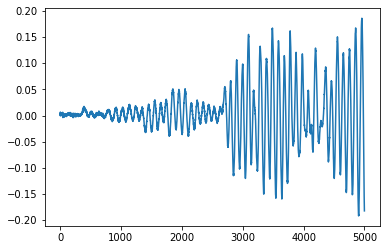

In [138]:
# 5MHz探頭針對第100號頻段偵測出來的信號
import matplotlib.pyplot as plt
plt.plot(np.arange(0,5000,1),x_5hz.iloc[100,:])

In [139]:
x_10hz = nd_00_10hz.append(nd_90_10hz, ignore_index=True)
x_10hz

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,-0.007202,-0.008301,-0.007935,-0.008545,-0.010132,-0.007202,-0.007568,-0.006348,-0.006348,-0.005249,...,-0.002686,-0.000244,-0.003418,-0.003662,-0.004395,-0.004883,-0.004150,-0.004883,-0.005249,-0.005371
1,-0.008545,-0.008911,-0.008301,-0.005493,-0.008179,-0.008911,-0.008667,-0.006226,-0.006836,-0.005615,...,-0.003174,-0.003296,-0.003662,-0.003418,-0.002441,-0.003906,-0.005859,-0.005127,-0.004639,-0.005371
2,-0.008179,-0.008301,-0.007812,-0.006470,-0.005371,-0.006836,-0.006836,-0.007446,-0.007080,-0.007935,...,-0.000977,-0.001099,-0.003296,-0.002686,-0.002930,-0.004883,-0.004150,-0.005371,-0.004272,-0.005371
3,-0.008423,-0.006958,-0.006958,-0.009277,-0.008301,-0.007324,-0.005737,-0.007080,-0.009033,-0.003662,...,-0.002441,-0.002075,-0.005371,-0.006226,-0.005249,-0.004150,-0.006836,-0.005005,-0.005005,-0.005737
4,-0.007568,-0.008789,-0.009521,-0.009888,-0.009155,-0.007202,-0.006104,-0.005493,-0.004517,-0.005005,...,-0.001465,-0.001099,-0.004761,-0.005127,-0.004395,-0.003784,-0.004150,-0.005249,-0.006592,-0.003174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.007324,-0.007568,-0.009033,-0.007324,-0.004883,-0.007202,-0.009888,-0.005249,-0.006104,-0.007568,...,-0.001587,-0.003540,-0.004150,-0.005127,-0.005127,-0.004028,-0.003174,-0.005371,-0.005981,-0.003906
3996,-0.009155,-0.007935,-0.007935,-0.007690,-0.008301,-0.008179,-0.011597,-0.010010,-0.009766,-0.005737,...,-0.002197,-0.001831,-0.003662,-0.003906,-0.004028,-0.005737,-0.005737,-0.003174,-0.005005,-0.005859
3997,-0.008911,-0.007446,-0.006714,-0.009277,-0.007202,-0.008301,-0.007080,-0.006348,-0.005005,-0.005493,...,-0.003784,-0.002075,-0.001831,-0.001099,-0.002075,-0.004761,-0.004761,-0.001953,-0.004395,-0.008301
3998,-0.006470,-0.008789,-0.008789,-0.007446,-0.006714,-0.006226,-0.005981,-0.007080,-0.009033,-0.008911,...,-0.001831,-0.001221,-0.001953,-0.004883,-0.003662,-0.004150,-0.004517,-0.005737,-0.004150,-0.004150


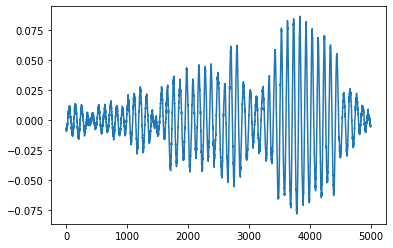

In [140]:
# 10MHz探頭針對第100號頻段偵測出來的信號
import matplotlib.pyplot as plt
plt.plot(np.arange(0,5000,1),x_10hz.iloc[100,:])

In [141]:
x_5hz = np.array(x_5hz[:])
x_5hz.shape

(4000, 5000)

In [142]:
x_10hz = np.array(x_10hz[:])
x_10hz.shape

(4000, 5000)

In [143]:
x = np.dstack((x_5hz, x_10hz))
x.shape

(4000, 5000, 2)

## 3. Train, Validate, Test split

In [144]:
from sklearn.model_selection import train_test_split

# split testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# split train & test data
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [145]:
x_train.shape

(3600, 5000, 2)

In [146]:
y_train.shape

(3600,)

In [147]:
x_train_5hz, x_train_10hz = np.moveaxis(x_train, -1, 0)

In [148]:
#x_valid_5hz, x_valid_10hz = np.moveaxis(x_valid, -1, 0)

In [149]:
x_test_5hz, x_test_10hz = np.moveaxis(x_test, -1, 0)

In [150]:
x_train_5hz.shape

(3600, 5000)

In [151]:
x_train_5hz = x_train_5hz.reshape(x_train_5hz.shape[0],x_train_5hz.shape[1], 1)
x_train_10hz = x_train_10hz.reshape(x_train_10hz.shape[0],x_train_10hz.shape[1], 1)

In [152]:
#x_valid_5hz = x_valid_5hz.reshape(x_valid_5hz.shape[0],x_valid_5hz.shape[1], 1)
#x_valid_10hz = x_valid_10hz.reshape(x_valid_10hz.shape[0],x_valid_10hz.shape[1], 1)

In [153]:
x_test_5hz = x_test_5hz.reshape(x_test_5hz.shape[0],x_test_5hz.shape[1], 1)
x_test_10hz = x_test_10hz.reshape(x_test_10hz.shape[0],x_test_10hz.shape[1], 1)

In [154]:
x_train_5hz.shape

(3600, 5000, 1)

## 4. Train the multi-scale CNN model

## 4-1 Two-input multi-scale CNN model
以5MHz以及10MHz探頭的資料，同時輸入一維度的CNN模型，合併後做前饋式神經網路。(如下圖) <br/>
<img src="https://drive.google.com/uc?export=view&id=1tMfO7mNQRLeVDWuEzFGyjL317-OMS-Oq"  width="600" height="600">

In [155]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, concatenate
from keras import regularizers
import pydot
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [156]:
#this is the main model
#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
inputs_lens = [5000, 5000]
fsizes = [50,50]

#choose the number of convolution filters
nb_filters = 32

#the inputs to the branches are the original time series, and its down-sampled versions
input_5hz = Input(shape=(inputs_lens[0], 1))


#1-D convolution and global max-pooling
convolved_5hz = Conv1D(nb_filters, fsizes[0], padding="same", activation="tanh")(input_5hz)
normal_5hz = BatchNormalization()(convolved_5hz)
pooling_5hz = GlobalMaxPooling1D()(normal_5hz)

#dense layer with dropout regularization
compressed_5hz = Dense(50, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling_5hz)
compressed_5hz = Dropout(0.3)(compressed_5hz)
embedding_5hz = Model(inputs=input_5hz, outputs=compressed_5hz)


input_10hz = Input(shape=(inputs_lens[1], 1))

#1-D convolution and global max-pooling
convolved_10hz = Conv1D(nb_filters, fsizes[1], padding="same", activation="tanh")(input_10hz)
normal_10hz = BatchNormalization()(convolved_10hz)
pooling_10hz = GlobalMaxPooling1D()(normal_10hz)

#dense layer with dropout regularization
compressed_10hz = Dense(50, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling_10hz)
compressed_10hz = Dropout(0.3)(compressed_10hz)
embedding_10hz = Model(inputs=input_10hz, outputs=compressed_10hz)

#concatenate all the outputs
   
merged = Concatenate(axis=1)([embedding_5hz.output, embedding_10hz.output])

hidden1 = Dense(10, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(merged)
drop_hidden1 = Dropout(0.2)(hidden1)
hidden2 = Dense(10, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop_hidden1)
drop_hidden2 = Dropout(0.2)(hidden2)

out = Dense(4, activation='softmax')(drop_hidden2)
model = Model(inputs=[input_5hz, input_10hz], outputs=out) 

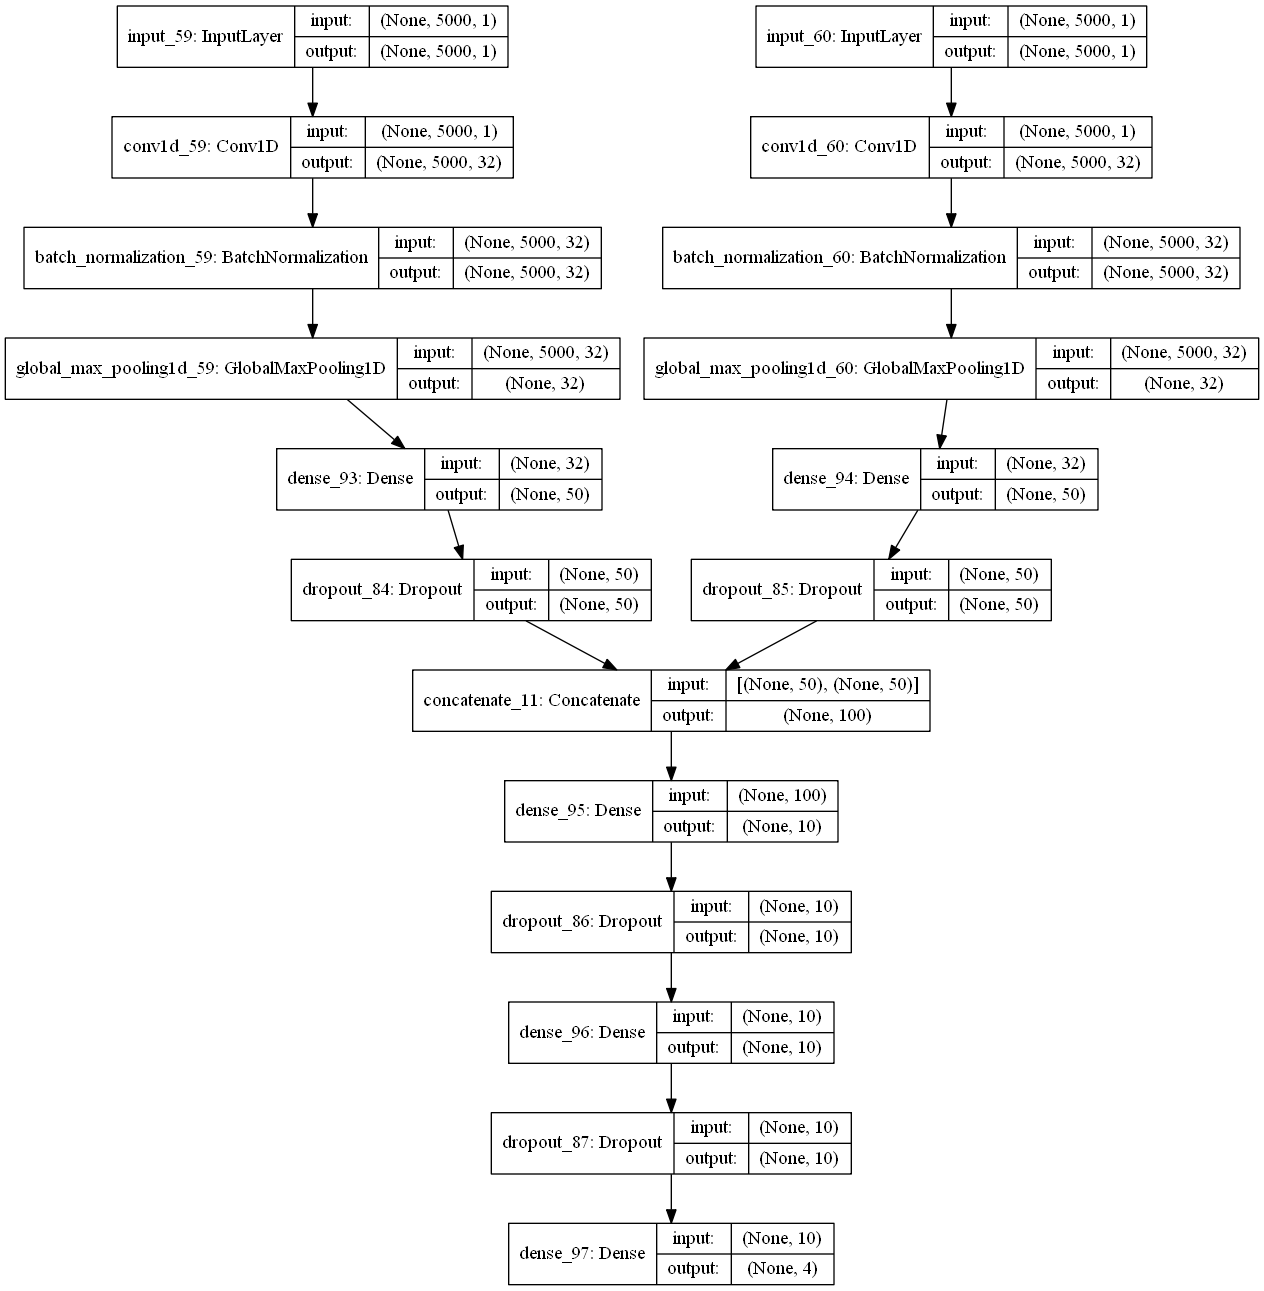

In [157]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [158]:
model.summary()

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 5000, 1)      0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           (None, 5000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_59 (Conv1D)              (None, 5000, 32)     1632        input_59[0][0]                   
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 5000, 32)     1632        input_60[0][0]                   
___________________________________________________________________________________________

In [159]:
from keras.optimizers import SGD
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [160]:

opt = SGD(lr=0.01)
model.compile(loss=["sparse_categorical_crossentropy"], optimizer=opt, metrics=['mse','acc',f1_m,precision_m, recall_m])

In [161]:
history = model.fit([x_train_5hz, x_train_10hz], y_train, epochs = 10, validation_split= 0.2,  batch_size=20) #validation_data = (x_valid, y_valid)

Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 49s 17ms/step - loss: 0.9387 - mse: 6.4726 - acc: 0.6993 - f1_m: 2.3601 - precision_m: 21597222.0000 - recall_m: 1.7951 - val_loss: 0.9768 - val_mse: 6.4682 - val_acc: 0.8194 - val_f1_m: 4.9997 - val_precision_m: 350555552.0000 - val_recall_m: 2.5368
Epoch 2/10
2880/2880 [==============================] - 51s 18ms/step - loss: 0.7631 - mse: 6.4974 - acc: 0.8083 - f1_m: 1.5090 - precision_m: 1.6333 - recall_m: 1.4105 - val_loss: 0.8337 - val_mse: 6.4846 - val_acc: 0.8194 - val_f1_m: 2.3358 - val_precision_m: 2.3311 - val_recall_m: 2.3409
Epoch 3/10
2880/2880 [==============================] - 51s 18ms/step - loss: 0.7201 - mse: 6.5017 - acc: 0.8101 - f1_m: 1.3410 - precision_m: 1.3900 - recall_m: 1.2987 - val_loss: 0.6962 - val_mse: 6.5163 - val_acc: 0.8194 - val_f1_m: 1.5528 - val_precision_m: 1.5486 - val_recall_m: 1.5572
Epoch 4/10
2880/2880 [==============================] - 59s 20

In [162]:
# evaluate the model
loss, mse, accuracy, f1_score, precision, recall = model.evaluate([x_test_5hz, x_test_10hz], y_test, verbose=0)

In [163]:
model.evaluate([x_test_5hz, x_test_10hz], y_test, verbose=0)

[0.5948981022834778,
 6.660393714904785,
 0.8299999833106995,
 0.9975579977035522,
 0.995192289352417,
 1.0]

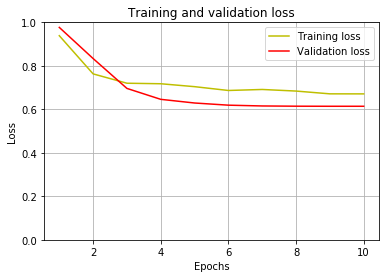

In [164]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

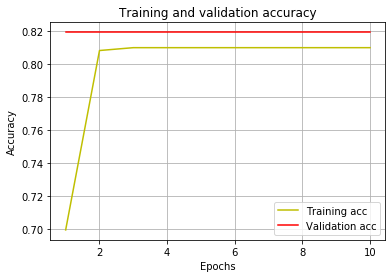

In [165]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

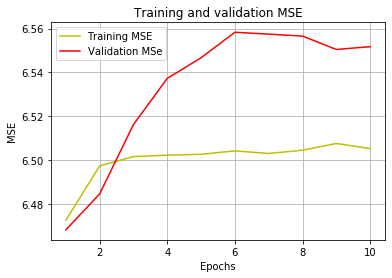

In [166]:
mse = history.history['mse']
val_mse = history.history['val_mse']
plt.plot(epochs, mse, 'y', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSe')
plt.title('Training and validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## 4-2 Six-input multi-scale CNN model
除5MHz及10MHz探頭的資料外，同時輸入兩種smoothing後的資料序列(分別為窗格大小5以及10)，共六種序列資料輸入進一維度的CNN模型，合併後做前饋式神經網路訓練。<br/>

<img src="https://drive.google.com/uc?export=view&id=1imhaeYUsoFWjfmz0rYWg2ZmMSS5Udn3a"  width="1000" height="900">

In [167]:
df_5hz = pd.DataFrame(data=x_5hz,    # values
             index=range(0,4000),    # 1st column as index
             columns=range(0,5000))

df_10hz = pd.DataFrame(data=x_10hz,    # values
             index=range(0,4000),    # 1st column as index
             columns=range(0,5000))

In [168]:
s5 = (df_5hz.columns.to_series() / 5).astype(int)
smoothing_5hz_5 = df_5hz.groupby(s5, axis=1).mean()
smoothing_10hz_5 = df_10hz.groupby(s5, axis=1).mean()
smoothing_10hz_5.shape

(4000, 1000)

In [169]:
s10 = (df_5hz.columns.to_series() / 10).astype(int)
smoothing_5hz_10 = df_5hz.groupby(s10, axis=1).mean()
smoothing_10hz_10 = df_10hz.groupby(s10, axis=1).mean()
smoothing_10hz_10.shape

(4000, 500)

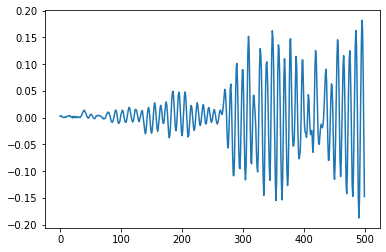

In [170]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,500,1),smoothing_5hz_10.iloc[100,:])

In [180]:
smoothing_5hz_5 = smoothing_5hz_5.to_numpy()
smoothing_10hz_5 = smoothing_10hz_5.to_numpy()
smoothing_5hz_10 = smoothing_5hz_10.to_numpy()
smoothing_10hz_10 = smoothing_10hz_10.to_numpy()

In [181]:
smoothing_5hz_5_train, smoothing_5hz_5_test = train_test_split(smoothing_5hz_5, test_size=0.1, random_state=42)
#smoothing_5hz_5_train, smoothing_5hz_5_val = train_test_split(smoothing_5hz_5_train, test_size=0.2, random_state=42)

smoothing_10hz_5_train, smoothing_10hz_5_test = train_test_split(smoothing_10hz_5, test_size=0.1, random_state=42)
#smoothing_10hz_5_train, smoothing_10hz_5_val = train_test_split(smoothing_10hz_5_train, test_size=0.2, random_state=42)

smoothing_5hz_10_train, smoothing_5hz_10_test = train_test_split(smoothing_5hz_10, test_size=0.1, random_state=42)
#smoothing_5hz_10_train, smoothing_5hz_10_val = train_test_split(smoothing_5hz_10_train, test_size=0.2, random_state=42)

smoothing_10hz_10_train, smoothing_10hz_10_test = train_test_split(smoothing_10hz_10, test_size=0.1, random_state=42)
#smoothing_10hz_10_train, smoothing_5hz_5_val = train_test_split(smoothing_10hz_10_train, test_size=0.2, random_state=42)

In [182]:
smoothing_5hz_5_train = smoothing_5hz_5_train.reshape(smoothing_5hz_5_train.shape[0],smoothing_5hz_5_train.shape[1], 1)
smoothing_10hz_5_train = smoothing_10hz_5_train.reshape(smoothing_10hz_5_train.shape[0],smoothing_10hz_5_train.shape[1], 1)
smoothing_5hz_10_train = smoothing_5hz_10_train.reshape(smoothing_5hz_10_train.shape[0],smoothing_5hz_10_train.shape[1], 1)
smoothing_10hz_10_train = smoothing_10hz_10_train.reshape(smoothing_10hz_10_train.shape[0],smoothing_10hz_10_train.shape[1], 1)

smoothing_5hz_5_test = smoothing_5hz_5_test.reshape(smoothing_5hz_5_test.shape[0],smoothing_5hz_5_test.shape[1], 1)
smoothing_10hz_5_test = smoothing_10hz_5_test.reshape(smoothing_10hz_5_test.shape[0],smoothing_10hz_5_test.shape[1], 1)
smoothing_5hz_10_test = smoothing_5hz_10_test.reshape(smoothing_5hz_10_test.shape[0],smoothing_5hz_10_test.shape[1], 1)
smoothing_10hz_10_test = smoothing_10hz_10_test.reshape(smoothing_10hz_10_test.shape[0],smoothing_10hz_10_test.shape[1], 1)

In [172]:
#this is the main model
#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
inputs_lens = [5000, 5000, 1000, 1000, 500, 500]
fsizes = [50, 50, 10, 10, 5, 5]

#choose the number of convolution filters
nb_filters = 32

## the inputs to the branches are the original time series, and its down-sampled versions
input_5hz = Input(shape=(inputs_lens[0], 1))


#1-D convolution and global max-pooling
convolved_5hz = Conv1D(nb_filters, fsizes[0], padding="same", activation="tanh")(input_5hz)
normal_5hz = BatchNormalization()(convolved_5hz)
pooling_5hz = GlobalMaxPooling1D()(normal_5hz)

#dense layer with dropout regularization
compressed_5hz = Dense(50, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling_5hz)
compressed_5hz = Dropout(0.3)(compressed_5hz)
embedding_5hz = Model(inputs=input_5hz, outputs=compressed_5hz)


## the inputs to the branches are the original time series, and its down-sampled versions
input_10hz = Input(shape=(inputs_lens[1], 1))

#1-D convolution and global max-pooling
convolved_10hz = Conv1D(nb_filters, fsizes[1], padding="same", activation="tanh")(input_10hz)
normal_10hz = BatchNormalization()(convolved_10hz)
pooling_10hz = GlobalMaxPooling1D()(normal_10hz)

#dense layer with dropout regularization
compressed_10hz = Dense(50, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling_10hz)
compressed_10hz = Dropout(0.3)(compressed_10hz)
embedding_10hz = Model(inputs=input_10hz, outputs=compressed_10hz)


## the inputs to the branches are the original time series, and its down-sampled versions
input_smooth5_5hz = Input(shape=(inputs_lens[2], 1))

#1-D convolution and global max-pooling
convolved_smooth5_5hz = Conv1D(nb_filters, fsizes[2], padding="same", activation="tanh")(input_smooth5_5hz)
normal_smooth5_5hz = BatchNormalization()(convolved_smooth5_5hz)
pooling_smooth5_5hz = GlobalMaxPooling1D()(normal_smooth5_5hz)

#dense layer with dropout regularization
compressed_smooth5_5hz = Dense(10, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling_smooth5_5hz)
compressed_smooth5_5hz = Dropout(0.3)(compressed_smooth5_5hz)
embedding_smooth5_5hz = Model(inputs=input_smooth5_5hz, outputs=compressed_smooth5_5hz)


## the inputs to the branches are the original time series, and its down-sampled versions
input_smooth5_10hz = Input(shape=(inputs_lens[3], 1))

#1-D convolution and global max-pooling
convolved_smooth5_10hz = Conv1D(nb_filters, fsizes[3], padding="same", activation="tanh")(input_smooth5_10hz)
normal_smooth5_10hz = BatchNormalization()(convolved_smooth5_10hz)
pooling_smooth5_10hz = GlobalMaxPooling1D()(normal_smooth5_10hz)

#dense layer with dropout regularization
compressed_smooth5_10hz = Dense(10, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling_smooth5_10hz)
compressed_smooth5_10hz = Dropout(0.3)(compressed_smooth5_10hz)
embedding_smooth5_10hz = Model(inputs=input_smooth5_10hz, outputs=compressed_smooth5_10hz)


## the inputs to the branches are the original time series, and its down-sampled versions
input_smooth10_5hz = Input(shape=(inputs_lens[4], 1))

#1-D convolution and global max-pooling
convolved_smooth10_5hz = Conv1D(nb_filters, fsizes[4], padding="same", activation="tanh")(input_smooth10_5hz)
normal_smooth10_5hz = BatchNormalization()(convolved_smooth10_5hz)
pooling_smooth10_5hz = GlobalMaxPooling1D()(normal_smooth10_5hz)

#dense layer with dropout regularization
compressed_smooth10_5hz = Dense(5, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling_smooth10_5hz)
compressed_smooth10_5hz = Dropout(0.3)(compressed_smooth10_5hz)
embedding_smooth10_5hz = Model(inputs=input_smooth10_5hz, outputs=compressed_smooth10_5hz)


## the inputs to the branches are the original time series, and its down-sampled versions
input_smooth10_10hz = Input(shape=(inputs_lens[5], 1))

#1-D convolution and global max-pooling
convolved_smooth10_10hz = Conv1D(nb_filters, fsizes[5], padding="same", activation="tanh")(input_smooth10_10hz)
normal_smooth10_10hz = BatchNormalization()(convolved_smooth10_10hz)
pooling_smooth10_10hz = GlobalMaxPooling1D()(normal_smooth10_10hz)

#dense layer with dropout regularization
compressed_smooth10_10hz = Dense(5, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling_smooth10_10hz)
compressed_smooth10_10hz = Dropout(0.3)(compressed_smooth10_10hz)
embedding_smooth10_10hz = Model(inputs=input_smooth10_10hz, outputs=compressed_smooth10_10hz)


#concatenate all the outputs 
merged = Concatenate(axis=1)([embedding_5hz.output, embedding_10hz.output, embedding_smooth5_5hz.output, embedding_smooth5_10hz.output, embedding_smooth10_5hz.output, embedding_smooth10_10hz.output])

hidden1 = Dense(40, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(merged)
drop_hidden1 = Dropout(0.2)(hidden1)
hidden2 = Dense(20, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop_hidden1)
drop_hidden2 = Dropout(0.2)(hidden2)
hidden3 = Dense(10, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop_hidden2)
drop_hidden3 = Dropout(0.2)(hidden3)

out = Dense(4, activation='softmax')(drop_hidden3)
model = Model(inputs=[input_5hz, input_10hz, input_smooth5_5hz, input_smooth5_10hz, input_smooth10_5hz, input_smooth10_10hz], outputs=out) 

In [ ]:
# Use Functional API

#this base model is one branch of the main model
#it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation

def get_base_model(input_len, fsize):
    #the input is a time series of length n and width 1
    input_seq = Input(shape=(input_len, 1))

    #choose the number of convolution filters
    nb_filters = 32
    #1-D convolution and global max-pooling
    convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
    normal = BatchNormalization()(convolved)
    pooling = GlobalMaxPooling1D()(normal)

    #dense layer with dropout regularization
    compressed = Dense(50, activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pooling)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)

    return model

In [ ]:
#this is the main model
#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def main_model(inputs_lens = [5000, 5000, 1000, 1000, 500, 500], fsizes = [50,50]):
    #the inputs to the branches are the original time series, and its down-sampled versions
    input_5hz = Input(shape=(inputs_lens[0], 1))
    input_10hz = Input(shape=(inputs_lens[1], 1))

    #the more down-sampled the time series, the shorter the corresponding filter
    base_net_5hz = get_base_model(inputs_lens[0], fsizes[0])
    base_net_10hz = get_base_model(inputs_lens[1], fsizes[1])

    embedding_5hz = base_net_5hz(input_5hz)
    embedding_10hz = base_net_10hz(input_10hz)

    #concatenate all the outputs
    merged = Concatenate()([embedding_5hz, embedding_10hz])
    
    hidden1 = Dense(10, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(merged)
    drop_hidden1 = Dropout(0.2)(hidden1)
    hidden2 = Dense(10, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop_hidden1)
    drop_hidden2 = Dropout(0.2)(hidden2)

    out = Dense(4, activation='softmax')(drop_hidden2)
    model = Model(inputs=[input_5hz, input_10hz], outputs=out)

    return model

In [173]:
model.summary()

Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 5000, 1)      0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           (None, 5000, 1)      0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           (None, 1000, 1)      0                                            
___________________________________________________________________________________________

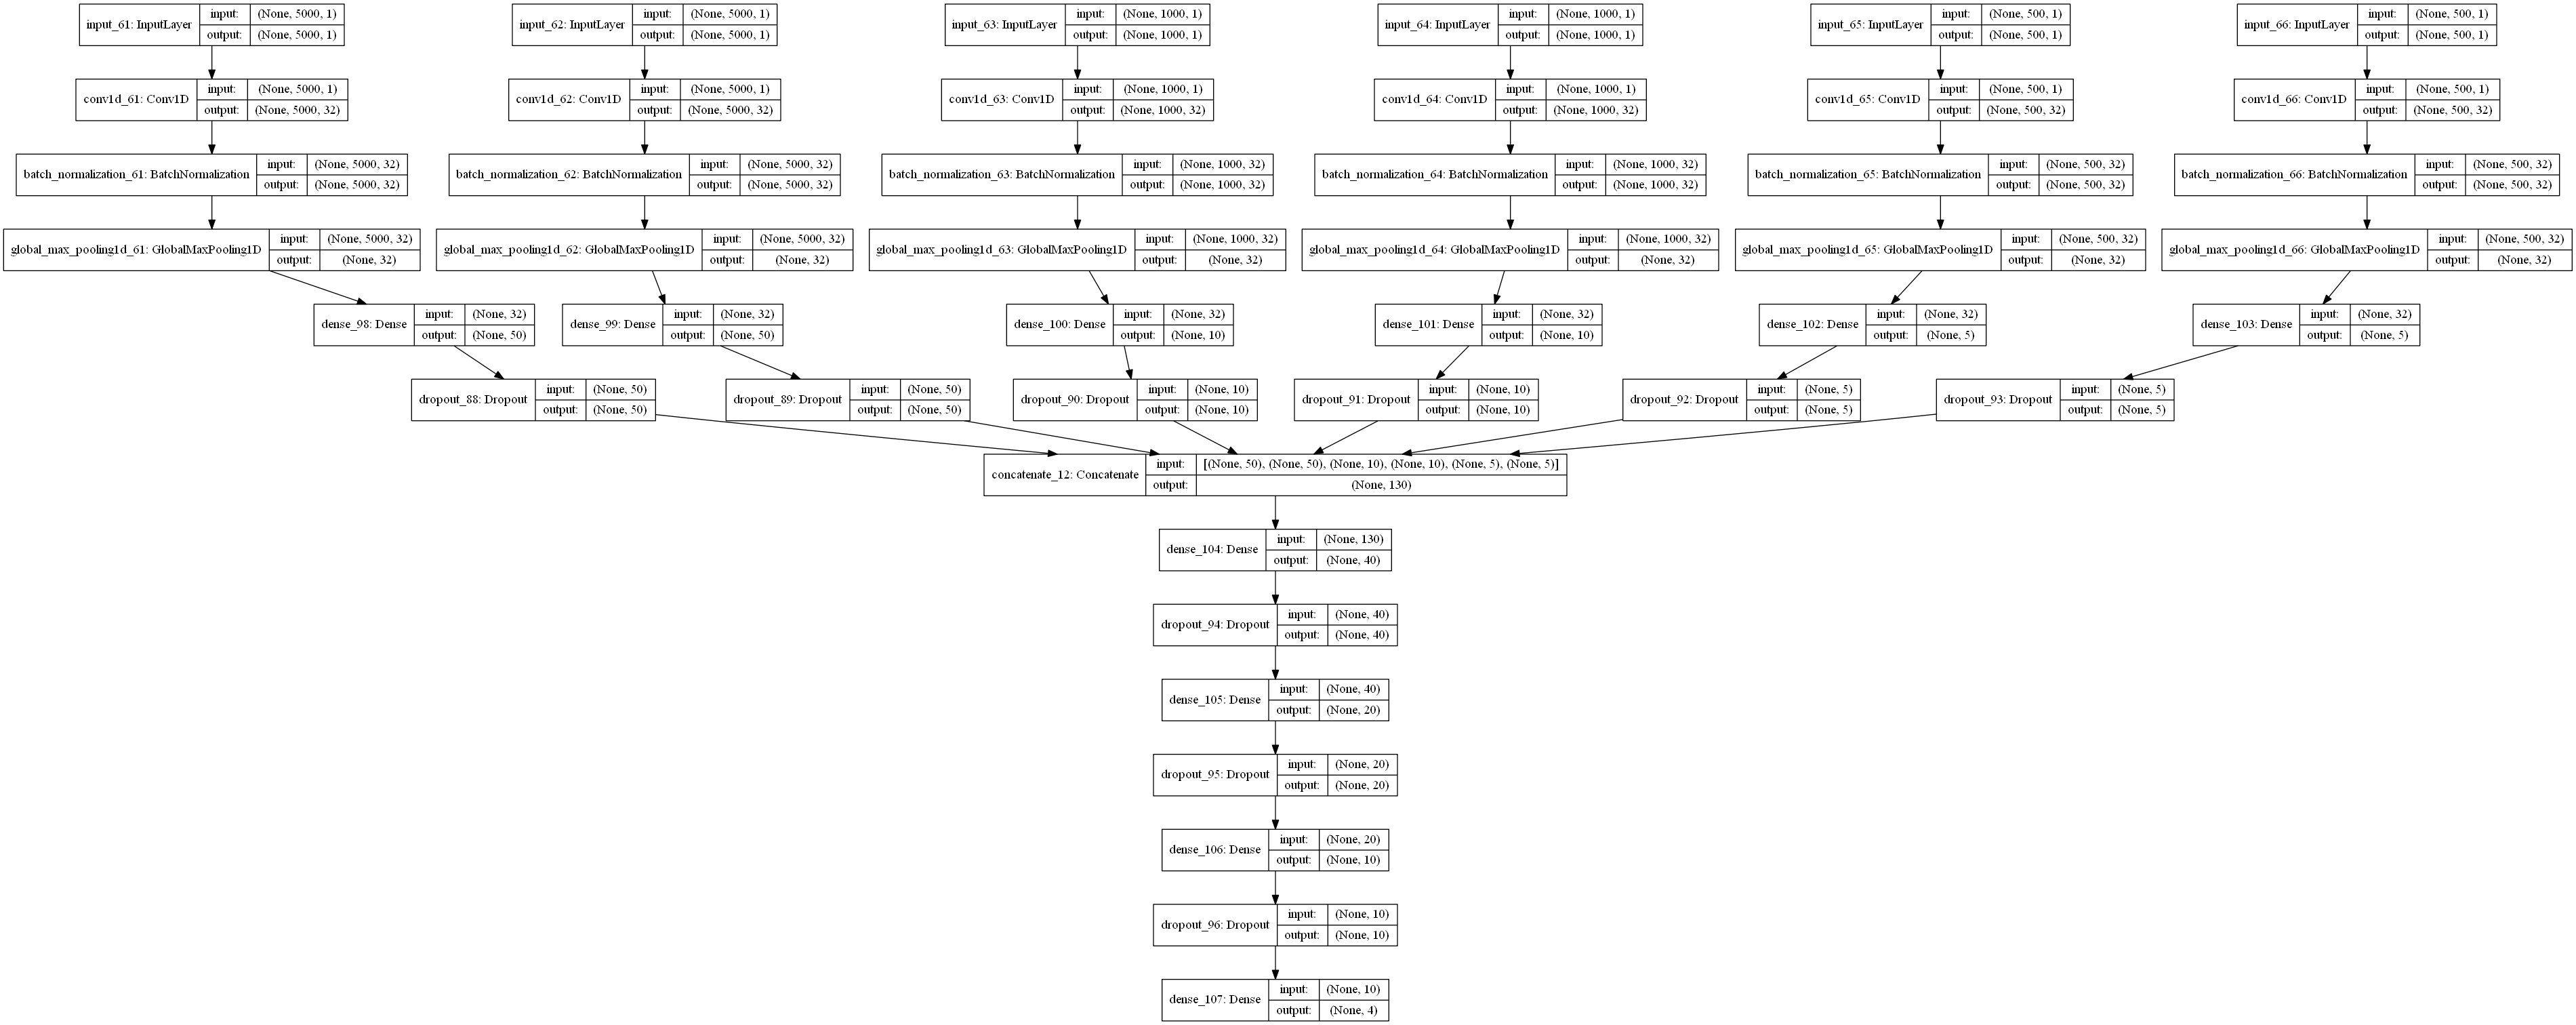

In [174]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [175]:
opt = SGD(lr=0.01)
model.compile(loss=["sparse_categorical_crossentropy"], optimizer=opt, metrics=['mse','acc',f1_m,precision_m, recall_m])

In [183]:
history = model.fit([x_train_5hz, x_train_10hz, smoothing_5hz_5_train, smoothing_10hz_5_train, smoothing_5hz_10_train, smoothing_10hz_10_train], y_train, epochs = 10, validation_split= 0.2,  batch_size=20) #validation_data = (x_valid, y_valid)

Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 70s 24ms/step - loss: 0.9270 - mse: 6.4705 - acc: 0.7139 - f1_m: 2.5294 - precision_m: 82638896.0000 - recall_m: 1.8311 - val_loss: 1.0158 - val_mse: 6.4667 - val_acc: 0.8194 - val_f1_m: 5.0737 - val_precision_m: 504444416.0000 - val_recall_m: 2.5368
Epoch 2/10
2880/2880 [==============================] - 68s 24ms/step - loss: 0.7579 - mse: 6.4982 - acc: 0.8083 - f1_m: 1.4392 - precision_m: 1.5059 - recall_m: 1.3843 - val_loss: 0.8446 - val_mse: 6.4853 - val_acc: 0.8194 - val_f1_m: 2.4074 - val_precision_m: 2.4119 - val_recall_m: 2.4040
Epoch 3/10
2880/2880 [==============================] - 84s 29ms/step - loss: 0.7336 - mse: 6.5014 - acc: 0.8097 - f1_m: 1.3616 - precision_m: 1.3993 - recall_m: 1.3281 - val_loss: 0.7273 - val_mse: 6.5094 - val_acc: 0.8194 - val_f1_m: 1.7715 - val_precision_m: 1.7667 - val_recall_m: 1.7767
Epoch 4/10
2880/2880 [==============================] - 69s 24

In [ ]:
model.evaluate([x_test_5hz, x_test_10hz], y_test, verbose=0)

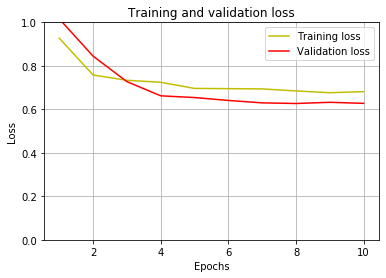

In [184]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

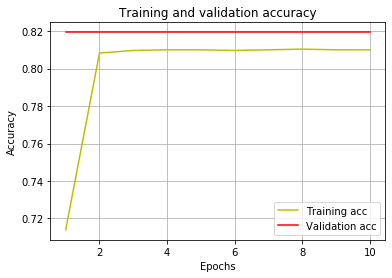

In [185]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 5. Conclusion
The results appear that both model perform similarly. The loss and accuracy converge around 0.6 and 0.83, which illustrate that simply using smoothing as our feature engineering tool is not enough. The smoothing data are still quite similar as orignal time series data. Future works can be using Fourier transormation to decompose the signal into different dimensioin, or using wavelet analysis to transform one dimension signal into two dimension scalogram, which provide more information and can be dealt by 2 dimensional CNN.

## 6. Reference
1. Ko and Li (2019), "Sonoporation based on Gold Nano-droplets vaporization," National Taiwan University, July 2019.
2. https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57
3. https://medium.com/@Rehan_Sayyad/how-to-use-convolutional-neural-networks-for-time-series-classification-80575131a474
4. https://medium.com/@hanify/sequential-api-vs-functional-api-model-in-keras-266823d7cd5e
5. https://stackoverflow.com/questions/46503816/keras-conv1d-layer-parameters-filters-and-kernel-size
6. https://stackoverflow.com/questions/43235531/convolutional-neural-network-conv1d-input-shape
7. https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442